In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import animatplot as amp
import lmfit
from lmfit import Minimizer, Parameters, report_fit
import scipy.stats as sps

In [2]:
@numba.jit(nopython=True)

# this function determines the coupling energy based on the location of the spin
def rates_2d_numba(J,H,state,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to external field
    field = H*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field))

In [3]:
@numba.jit(nopython=True)

# function that implements dynamic Ising model using Gillespie's algorithm
def ensemble_averaged_ising(n_samples,n_steps,tf,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):

    # array to store all results
    all_states = np.zeros((n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))
    
    ########################
    ### Actual algorithm ###
    ########################
    
    # loop over n_samples realisations of the algorithm
    for sample in range(n_samples):
        # initialise each realisation
        dt = 0
        time = 0
        
        # initialise
        state = np.random.choice(np.array([-1.,1.]),size=(L,L))
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))
            
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
              
            # keep updating until we reach the end of this regular time step
            while time < t_grid[step]:
                # flip the spin
                state[m,l] *= -1
                
                # obtain rates of flipping
                rates = rates_2d_numba(J,H,state)
                Omega = np.sum(rates)
                
                # select which spin i is flipped
                p = np.random.uniform(0,1)*Omega
                mask = p < np.cumsum(rates)
                i = np.where(mask == True)[0][0]

                # convert to coordinates in the lattice
                m,l = np.divmod(i,L)

                # sample time until next event
                u1 = np.random.uniform(0,1)
                dt = -np.log(u1)/Omega
            
                # update time
                time += dt
                
            # save the last state before passing the boundary
            all_states[sample,step,:,:] = state
            
    #################
    ### Averaging ###
    #################
    
    # array to store ensemble average for each spin
    ensemble_av = np.zeros((n_steps,L,L),dtype='float64')
    
    # averaging (the weird numba way)
    for step in range(n_steps):
        for spin1 in range(L):
            for spin2 in range(L):
                ensemble_av[step,spin1,spin2] = np.mean(all_states[:,step,spin1,spin2])
        
    return all_states, ensemble_av, t_grid

In [4]:
# function for drawing poisson random variables on a square lattice in numba
@numba.jit(nopython=True)
def poisson(lattice):
    # array to store results and lattice size
    output = np.zeros_like(lattice)
    L = int(np.sqrt(lattice.size))
    
    # loop through all entries of the lattice
    for x in range(L):
        for y in range(L):
            output[x,y] = np.random.poisson(lam=lattice[x,y])
    
    return output


@numba.jit(nopython=True)
def ising_tau_leaping(n_samples,n_steps,tf,L,J,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900):
    
    # array to store all results
    all_states = np.zeros((n_samples,n_steps,L,L),dtype='float64')
    n_flips = np.zeros((n_samples,n_steps),dtype='int')

    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)

    # extract tau
    tau = t_grid[1] - t_grid[0]

    # define zero energy
    # chosen such that average activity is 0.5 without coupling at c=100
    epsilon = -np.log((1 + 100/Ki)/(1 + 100/Ka))

    ########################
    ### Actual algorithm ###
    ########################

    # loop over n_samples realisations of the algorithm
    for sample in range(n_samples):
        # initialise
        state = np.random.choice(np.array([-1.,1.]),size=(L,L))

        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase

            # define the external field
            H = -0.5*(epsilon + np.log((1 + c/Ki)/(1 + c/Ka)))

            # obtain rates of flipping
            rates = rates_2d_numba(J,H,state)

            # sample which spins flip and count how many flip
            all_flip = poisson(rates*tau)
            n_flips[sample,step] = np.sum(all_flip >= 1)

            # only flip those spins for which a flip would occur equal to or more than once
            for spin1 in range(L):
                for spin2 in range(L):
                    if all_flip[spin1,spin2] >= 1:
                        state[spin1,spin2] *= -1

            # save the state
            all_states[sample,step,:,:] = state
                
    return all_states, t_grid

In [5]:
n_samples = 100
n_steps = 5000
L = 10
tf = 500
J = 0.4

%timeit ising_tau_leaping(n_samples,n_steps,tf,L,J)

%timeit ensemble_averaged_ising(n_samples,n_steps,tf,L,J)

5.35 s ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
22.7 s ± 31.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Verification of $\tau$-leaping

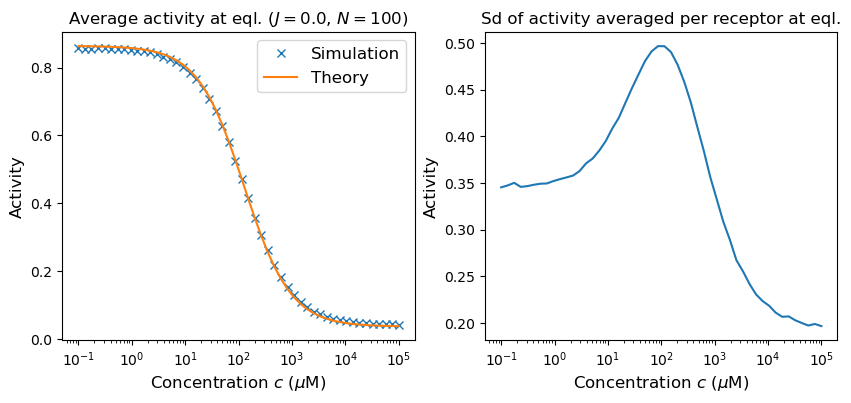

In [40]:
# check how this goes
n_samples = 1
L = 10
J = 0
n_steps = 2*10**4
tf = 1000
J = 0.

c_arr = np.logspace(-1,5,50)
all_avg_spin = np.empty(c_arr.size)
all_std_spin = np.empty(c_arr.size)

# loop through various concentrations
for i,c in enumerate(c_arr):    
    # obtain average magnetisation at equilibrium
    all_states, t_grid = ising_tau_leaping(n_samples,n_steps,tf,L,J,cbase=c)
    spins = all_states[0,:,:,:]
    std_spin = np.std(spins,axis=(1,2))
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[n_steps//3:])
    all_std_spin[i] = np.mean(std_spin[n_steps//3:])
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin
all_std_act = 0.5*all_std_spin

# check theoretical result
def theoretical_a(c,L,Ki=18,Ka=2900):
    epsilon = -np.log((1+100/Ki)/(1+100/Ka))
    return 0.5 + 0.5*np.tanh(-0.5*(epsilon + np.log((1+c/Ki)/(1+c/Ka))))

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.semilogx(c_arr,all_avg_act,'x',label='Simulation')
ax1.semilogx(c_arr,theoretical_a(c_arr,L),label='Theory')
#ax1.axvline(x=c_crit,ymin=0.05,ymax=0.95,color='r',linestyle=':')
ax1.set_xlabel(r'Concentration $c$ ($\mu$M)',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.legend(fontsize=12)
ax1.set_title(f'Average activity at eql. ($J = {J}$, $N={L**2}$)')

ax2.semilogx(c_arr,all_std_act,label='Average std at eql.')
ax2.set_xlabel(r'Concentration $c$ ($\mu$M)',size=12)
ax2.set_ylabel('Activity',size=12)
ax2.set_title('Sd of activity averaged per receptor at eql.')

plt.show()

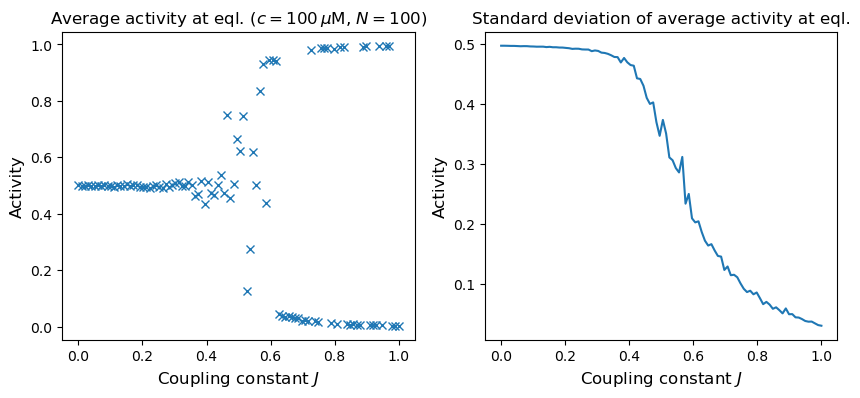

In [41]:
# obtain activity as function of J without external field
n_samples = 1
L = 10
J = 0
n_steps = 2*10**4
tf = 1000

J_arr = np.linspace(0,1,100)
all_avg_spin = np.empty(J_arr.size)
all_std_spin = np.empty(J_arr.size)

# loop through various concentrations
for i,J in enumerate(J_arr):
    # obtain average magnetisation at equilibrium
    all_states, t_grid = ising_tau_leaping(n_samples,n_steps,tf,L,J,cbase=100)
    spins = all_states[0,:,:,:]
    
    std_spin = np.std(spins,axis=(1,2))
    avg_spin = np.mean(spins,axis=(1,2))
    
    # truncate and take mean
    all_avg_spin[i] = np.mean(avg_spin[n_steps//3:])
    all_std_spin[i] = np.mean(std_spin[n_steps//3:])
    
# convert to activity
all_avg_act = 0.5 + 0.5*all_avg_spin
all_std_act = 0.5*all_std_spin

# show results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.plot(J_arr,all_avg_act,'x',label='Simulation')
ax1.set_xlabel(r'Coupling constant $J$',size=12)
ax1.set_ylabel('Activity',size=12)
ax1.set_title(f'Average activity at eql. ($c = 100\, \mu$M, $N={L**2}$)')

ax2.plot(J_arr,all_std_act,label='Average std at eql.')
ax2.set_xlabel(r'Coupling constant $J$',size=12)
ax2.set_ylabel('Activity',size=12)
ax2.set_title('Standard deviation of average activity at eql.')

plt.show()

## Response kernel

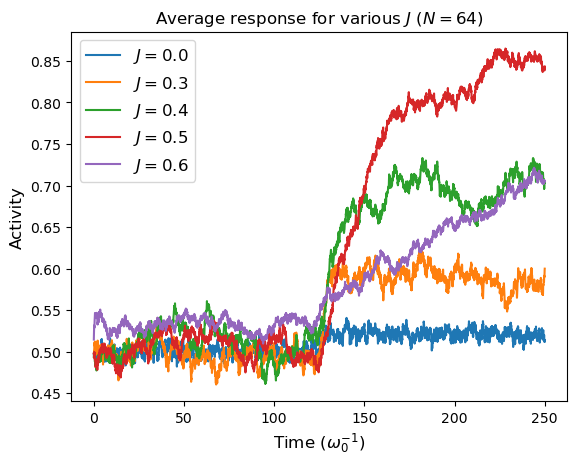

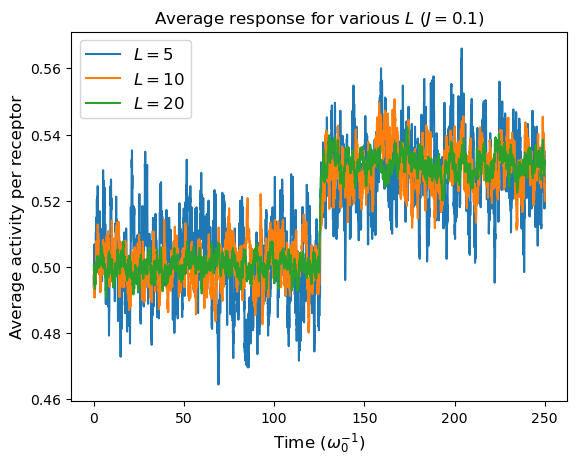

In [42]:
# obtain average response to a 10% decrease in concentration
n_samples = 10**2
n_steps = 5000
tf = 250
L = 8

for J in [0.,0.3,0.4,0.5,0.6]:
    # obtain results
    all_states, t_grid = ising_tau_leaping(n_samples,n_steps,tf,L,J,
                                                              cbase=100,cnew=90,step_change=2500)
    
    # convert to average activity
    ensemble_av_act = 0.5*np.mean(all_states,axis=0) + 0.5

    plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'$J = {J}$')

plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Activity',size=12)
plt.title(f'Average response for various $J$ ($N={L**2}$)')
plt.legend(fontsize=12)
plt.show()

# obtain response for various L
J = 0.1

for L in [5,10,20]:
    # obtain results
    all_states, t_grid = ising_tau_leaping(n_samples,n_steps,tf,L,J,
                                                              cbase=100,cnew=90,step_change=2500)
    
    # convert to average activity
    ensemble_av_act = 0.5*np.mean(all_states,axis=0) + 0.5

    plt.plot(t_grid,np.mean(ensemble_av_act,axis=(1,2)),label=f'$L ={L}$')

plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Average activity per receptor',size=12)
plt.title(f'Average response for various $L$ ($J={J}$)')
plt.legend(fontsize=12)
plt.show()

[0.18524356 1.06606071]
[0.50915435 1.20661993]
[0.5424321  2.11435346]
[1.27728982 4.77222078]
[ 3.02824764 15.1945483 ]
[  3.85053307 236.98970943]


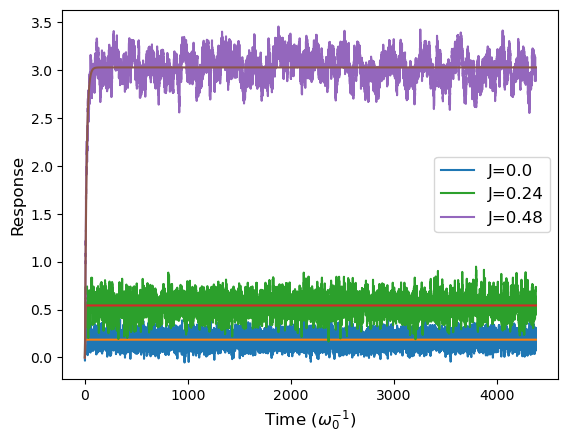

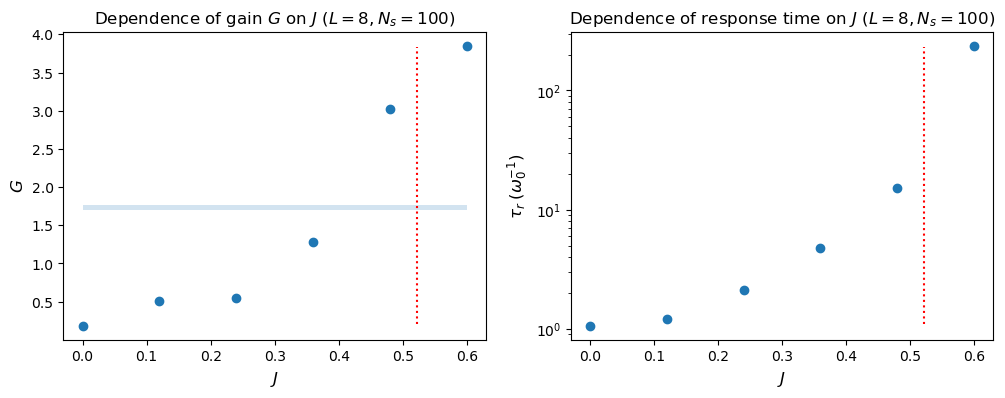

In [20]:
# define the model function
def Kstar(t,G,tau_r):
    # make sure encoded in 64 bits to avoid errors
    x = np.float64(-t/tau_r)
    return G*(1-np.exp(x))

# parameters
n_samples = 10**2
n_steps = 5*10**4
step_change = n_steps//8
tf = 5*10**3
L = 8

# values of J to scan over
J_arr = np.linspace(0.,0.6,6)

# arrays to store fitted parameters and error bars
parm_arr = np.zeros((2,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all values of J
for i,J in enumerate(J_arr):
    # obtain data
    all_states, t_grid = ising_tau_leaping(n_samples,n_steps,tf,L,J,
                                                              cbase=100,cnew=90,step_change=step_change)

    # transform to activity
    ensemble_av = np.mean(all_states,axis=0)
    activity = np.mean(0.5*(ensemble_av + 1),axis=(1,2))

    # find response and shift time
    shifted_activity = activity[step_change-1:] - activity[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting and store results
    popt, pcov = curve_fit(Kstar,shifted_time,response)
    print(popt)
    parm_arr[:,i] = popt
    sd_arr[:,i] = [np.sqrt(pcov[j,j]) for j in range(2)]

    # visual check for a few values
    if i % 2 == 0:
        plt.plot(shifted_time,response,label=f'J={np.round(J,2)}')
        plt.plot(shifted_time,Kstar(shifted_time,*popt))

plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
plt.ylabel('Response',size=12)
plt.legend(fontsize=12)
plt.show()

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

# show how the fitting parameters depend on J
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

for i,ax in enumerate((ax1, ax2)):
    ax.set_xlabel(r'$J$',size=12)
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle=':',color='r')
    
ax1.plot(J_arr,parm_arr[0,:],'o')
ax1.fill_between(J_arr,1.70,1.76,alpha=0.2)
ax1.set_ylabel(r'$G$',size=12)
ax1.set_title(f'Dependence of gain $G$ on $J$ ($L={L}, N_s={n_samples}$)')

ax2.semilogy(J_arr,parm_arr[1,:],'o')
ax2.set_ylabel(r'$\tau_r \; (\omega_0^{-1})$',size=12)
ax2.set_title(f'Dependence of response time on $J$ ($L={L}, N_s={n_samples}$)')

plt.show()

## Using Lmfit for fitting

In [5]:
# define the parameters object
parms = Parameters()
parms.add_many(('G', 0.1, True, 0.),('tau_r', 1, True, 0.))

def Kstar(t,parms):
    v = parms.valuesdict()
    return v['G']*(1-np.exp(-t/v['tau_r']))

# set up objective function as least-squares
def lsq(parms,xdata,ydata,yerr,model,output_resid=True):
    if output_resid == True:
        for i, x in enumerate(xdata):
            if i == 0:
                resid = (ydata[i]-model(x,parms))/yerr[i]
            else:
                resid = np.append(resid,(ydata[i]-model(x,parms))/yerr[i])
        return resid
    else:
        ymodel = []
        for i, x in enumerate(xdata):
            ymodel.append(model(x,parms))
        return ymodel

In [44]:
# generate data
n_samples = 10**2
n_steps = 5000
step_change = n_steps//4
tf = 500
L = 8
J = 0.4

all_states, t_grid = ising_tau_leaping(n_samples,n_steps,tf,L,J,
                                            cbase=100,cnew=90,step_change=step_change)

# find the standard deviations around the average at each time point
lattice_av = np.mean(0.5*all_states + 0.5, axis=(-1,-2))
std_response = np.std(lattice_av[:,step_change-1:]/np.log(100/90),axis=0)

# take ensemble-average
activity = np.mean(lattice_av,axis=0)

# find response and shift time
shifted_activity = activity[step_change-1:] - activity[step_change-1]
response = shifted_activity/np.log(100/90)
shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

In [45]:
# prepare the fitting
model = Kstar
output_resid = True
xdata = [shifted_time]
ydata = [response]
yerr = [std_response]
set_function = Minimizer(lsq, parms, fcn_args=(xdata, ydata, yerr, model, output_resid), nan_policy='omit')
result = set_function.minimize(method = 'leastsq')
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 3751
    # variables        = 2
    chi-square         = 31.3246900
    reduced chi-square = 0.00835548
    Akaike info crit   = -17945.9272
    Bayesian info crit = -17933.4676
[[Variables]]
    G:      2.13755064 +/- 0.00230613 (0.11%) (init = 0.1)
    tau_r:  7.66812671 +/- 0.12755229 (1.66%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(G, tau_r) = +0.2072


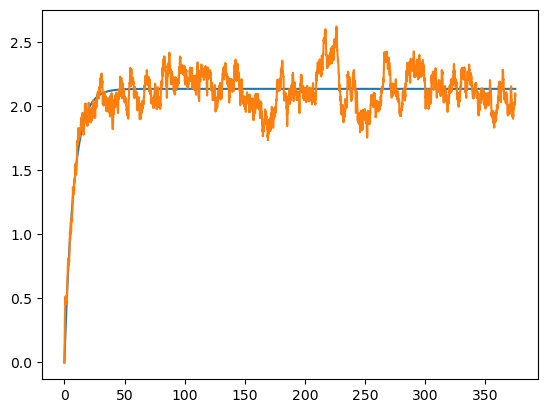

In [47]:
# extract model values
model_vals = lsq(result.params,xdata,ydata,yerr,model,output_resid=False)

plt.plot(shifted_time,model_vals[0])
plt.plot(shifted_time,response)

In [48]:
print('Minimum chi-sq:', result.chisqr)
print('DoF:',result.nfree)
print('Goodness-of-fit:', sps.chi2.sf(result.chisqr,df=result.nfree))

Minimum chi-sq: 31.32469003646842
DoF: 3749
Goodness-of-fit: 1.0


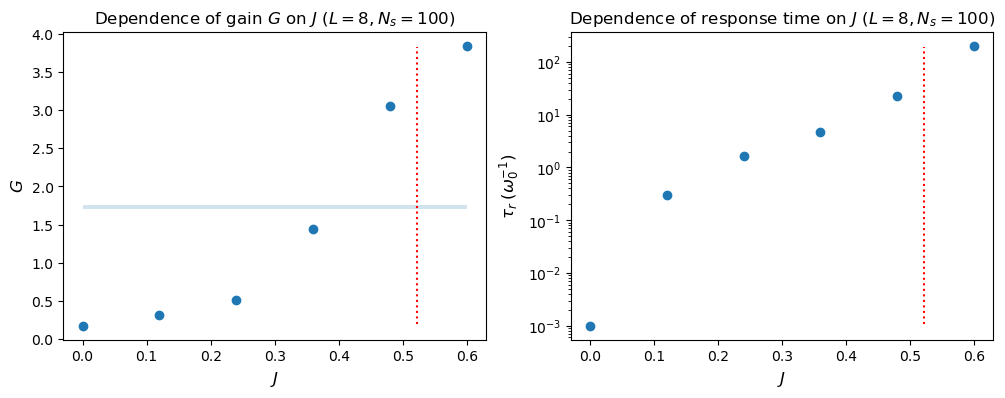

In [56]:
# parameters
n_samples = 10**2
n_steps = 5*10**4
step_change = n_steps//8
tf = 5*10**3
L = 8

# values of J to scan over
J_arr = np.linspace(0.,0.6,6)

# arrays to store fitted parameters and error bars
parm_arr = np.zeros((2,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# loop over all values of J
for i,J in enumerate(J_arr):
    all_states, t_grid = ising_tau_leaping(n_samples,n_steps,tf,L,J,
                                            cbase=100,cnew=90,step_change=step_change)

    # find the standard deviations around the average at each time point
    lattice_av = np.mean(0.5*all_states + 0.5, axis=(-1,-2))
    std_response = np.std(lattice_av[:,step_change-1:]/np.log(100/90),axis=0)

    # take ensemble-average
    activity = np.mean(lattice_av,axis=0)

    # find response and shift time
    shifted_activity = activity[step_change-1:] - activity[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting
    xdata = [shifted_time]
    ydata = [response]
    yerr = [std_response]
    set_function = Minimizer(lsq, parms, fcn_args=(xdata, ydata, yerr, model, output_resid), nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    
    # extract fitting results
    parm_arr[0,i] = result.params['G'].value
    sd_arr[0,i] = result.params['G'].stderr
    
    parm_arr[1,i] = result.params['tau_r'].value
    sd_arr[1,i] = result.params['tau_r'].stderr
    
#     # visual check for a few values
#     if i % 2 == 0:
#         plt.plot(shifted_time,response,label=f'J={np.round(J,2)}')
#         plt.plot(shifted_time,Kstar(shifted_time,*popt))

# plt.xlabel(r'Time $(\omega_0^{-1})$',size=12)
# plt.ylabel('Response',size=12)
# plt.legend(fontsize=12)
# plt.show()

# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

# show how the fitting parameters depend on J
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

for i,ax in enumerate((ax1, ax2)):
    ax.set_xlabel(r'$J$',size=12)
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle=':',color='r')
    
ax1.plot(J_arr,parm_arr[0,:],'-o')
ax1.fill_between(J_arr,1.70,1.76,alpha=0.2)
ax1.set_ylabel(r'$G$',size=12)
ax1.set_title(f'Dependence of gain $G$ on $J$ ($L={L}, N_s={n_samples}$)')

ax2.semilogy(J_arr,parm_arr[1,:],'-o')
ax2.set_ylabel(r'$\tau_r \; (\omega_0^{-1})$',size=12)
ax2.set_title(f'Dependence of response time on $J$ ($L={L}, N_s={n_samples}$)')

plt.show()

## Adaptation

In [6]:
@numba.jit(nopython=True)
# this function determines the rates of spin-flipping
# includes (de)methylation energy
def flip_rates_meth_cross(J,H,state,meth_state,m0,delta_fm,omega0=1):
    # shift the lattices and remove some neighbours for the edges
    left = np.empty(state.shape)
    right = np.empty(state.shape)
    top = np.empty(state.shape)
    bottom = np.empty(state.shape)
    
    # roll the states (in the dumb numba way)
    for i in range(state.shape[0]):
        left[i,:] = np.roll(state[i,:],1)
        right[i,:] = np.roll(state[i,:],-1)
        top[:,i] = np.roll(state[:,i],1)
        bottom[:,i] = np.roll(state[:,i],-1)
    
    # remove edges
    left[:,0] = 0.
    right[:,-1] = 0.
    top[0,:] = 0.
    bottom[-1,:] = 0.
    
    # compute coupling summation for each spin
    coupling = J*state*(left + right + top + bottom)
    
    # energy difference associated to methylation-independent external field
    field = H*state
    
    # energy difference due to methylation
    meth_energy = -0.5*delta_fm*(meth_state-m0)*state
    
    # return the rates
    return omega0*np.exp(-(coupling + field + meth_energy))

@numba.jit(nopython=True)
# function that finds the (de)methylation rates 
def demethylation_rates(state,meth_state,kR,kB):
    # array to store results
    demeth_rates = np.zeros_like(meth_state,dtype='float64')
    meth_rates = np.zeros_like(meth_state,dtype='float64')
 
    # loop through all receptors and check whether they can (de)methylate        
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            # demethylation
            if state[i,j] == 1 and meth_state[i,j] > 0:
                demeth_rates[i,j] = kB
                
            # methylation
            if state[i,j] == -1 and meth_state[i,j] < 4:
                meth_rates[i,j] = kR

    return demeth_rates, meth_rates

In [7]:
# function to draw a biased sample in numba
@numba.jit(nopython=True)
def biased_choice(outcomes,prob,L):
    return outcomes[np.searchsorted(np.cumsum(prob), np.random.rand(L**2))].reshape((L,L))

# function to simulate the receptor array with adaptation using tau-leaping
@numba.jit(nopython=True)
def meth_tau_leaping(n_samples,n_steps,tf,L,J,kR,kB,
                 step_change=10**9,cbase=100,cnew=100,Ki=18,Ka=2900,m0=0.5,delta_fm=-2):
    
    # array to store all results
    all_states = np.zeros((2,n_samples,n_steps,L,L),dtype='float64')
    
    # regular time steps
    t_grid = np.linspace(0,tf,n_steps)
    
    # extract tau
    tau = t_grid[1] - t_grid[0]
    
    # loop over all samples
    for sample in range(n_samples):        
        # intialise each realisation with a bias
        spin_state = biased_choice(np.array([-1.,1.]),np.array([2/3,1/3]),L)
        meth_state = biased_choice(np.arange(0,5),np.array([0.4,0.3,0.1,0.1,0.1]),L)
        
        # loop over all time steps
        for step in range(n_steps):
            # change concentration after some steps
            if step >= step_change:
                c = cnew
            else:
                c = cbase
                            
            # define the external field
            H = -0.5*np.log((1 + c/Ki)/(1 + c/Ka))
            
            # obtain flipping rates
            flip_rates = flip_rates_meth_cross(J,H,spin_state,meth_state,m0,delta_fm)
            
            # obtain (de)methylation rates
            demeth_rates, meth_rates = demethylation_rates(spin_state,meth_state,kR,kB)
            
            # sample which spins flip
            all_flip = poisson(flip_rates*tau)
            
            # only flip those spins for which a flip would occur equal to or more than once
            for spin1 in range(L):
                for spin2 in range(L):
                    if all_flip[spin1,spin2] >= 1:
                        spin_state[spin1,spin2] *= -1
                        
            # count how often each spin gets (de)methylated     
            change_meth = poisson(meth_rates*tau)
            change_demeth = poisson(demeth_rates*tau)
            
            # apply the (de)methylation
            for spin1 in range(L):
                for spin2 in range(L):
                    meth_state[spin1,spin2] += change_meth[spin1,spin2] - change_demeth[spin1,spin2]
                    
                    # make sure methylation levels are within bounds
                    if meth_state[spin1,spin2] < 0:
                        meth_state[spin1,spin2] = 0
                    elif meth_state[spin1,spin2] > 4:
                        meth_state[spin1,spin2] = 4
            
            # save the states
            all_states[0,sample,step,:,:] = spin_state
            all_states[1,sample,step,:,:] = meth_state
            
    # normalise methylation level
    all_states[1,:,:,:,:] *= 0.25
    
    return all_states, t_grid

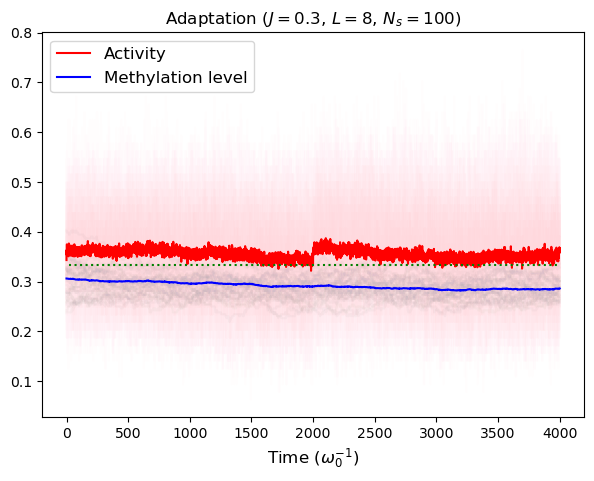

In [8]:
# parameters
omega0 = 67.
n_samples = 100
n_steps = 10**4
step_change = n_steps//2
tf = 4000
L = 8
J = 0.3
kR = 0.075/omega0
kB = 2*kR

# obtain results
all_states, t_grid = meth_tau_leaping(n_samples,n_steps,tf,L,J,kR,kB,cnew=90,step_change=step_change)

# show results
fig, ax = plt.subplots(1,1,figsize=(7,5))

# look at ensemble-averaged activity averaged over all spins for one realisation
for ff in range(n_samples//3):
    ax.plot(t_grid,0.5+0.5*np.mean(all_states[0,ff,:,:,:],axis=(1,2)),color='pink',alpha=0.02)
    ax.plot(t_grid,np.mean(all_states[1,ff,:,:,:],axis=(1,2)),color='grey',alpha=0.05)

ax.plot(t_grid,0.5*np.mean(all_states[0,:,:,:,:],axis=(0,-1,-2)) + 0.5,color='r',label='Activity')
ax.plot(t_grid,np.mean(all_states[1,:,:,:,:],axis=(0,-1,-2)),color='b',label='Methylation level')
ax.axhline(y=1/3,xmin=0.05,xmax=0.95,color='green',linestyle=':')
ax.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax.set_title(f'Adaptation $(J={J},\, L={L},\, N_s={n_samples})$',size=12)
ax.legend(fontsize=12)

plt.show()

## Characterising the Response Kernel

In [8]:
# define the parameters object
parms = Parameters()
parms.add_many(('G', 0., True, 0.),('tau_r', 1, True, 0.),('tau_a', 10, True, 0.))

def K(t,parms):
    v = parms.valuesdict()
    return v['G']*(1-np.exp(-t/v['tau_r']))*np.exp(-t/v['tau_a'])

# prepare the fitting
model = K
output_resid = True

In [ ]:
# parameters
n_steps = 10**4
step_change = n_steps//5
tf = 5*10**3
L = 8
n_samples = 1000
omega0 = 60.
kR = 0.075/omega0
kB = 2*kR

# values of J to scan over
J_arr = np.linspace(0.,0.6,5)

# arrays to store fitted parameters and error bars
parm_arr = np.zeros((3,J_arr.size))
sd_arr = np.zeros_like(parm_arr)

# prepare figure
fig, ax = plt.subplots(1,1, figsize=(8,6))

# loop over all values of J
for i,J in enumerate(J_arr):
    all_states, t_grid = meth_tau_leaping(n_samples,n_steps,tf,L,J,kR,kB,
                                          cnew=90,step_change=step_change)

    # find the standard deviations around the average at each time point
    lattice_av = np.mean(0.5*all_states[0,:,:,:,:] + 0.5, axis=(-1,-2))
    std_response = np.std(lattice_av[:,step_change-1:]/np.log(100/90),axis=0)

    # take ensemble-average
    activity = np.mean(lattice_av,axis=0)

    # find response and shift time
    shifted_activity = activity[step_change-1:] - activity[step_change-1]
    response = shifted_activity/np.log(100/90)
    shifted_time = t_grid[step_change-1:] - t_grid[step_change-1]

    # perform fitting
    xdata = [shifted_time]
    ydata = [response]
    yerr = [std_response]
    set_function = Minimizer(lsq, parms, fcn_args=(xdata, ydata, yerr, model, output_resid), nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    
    # extract fitting results
    parm_arr[0,i] = result.params['G'].value
    sd_arr[0,i] = result.params['G'].stderr
    
    parm_arr[1,i] = result.params['tau_r'].value
    sd_arr[1,i] = result.params['tau_r'].stderr
    
    parm_arr[2,i] = result.params['tau_a'].value
    sd_arr[2,i] = result.params['tau_a'].stderr
    
    # extract model values
    model_vals = lsq(result.params,xdata,ydata,yerr,model,output_resid=False)
    
    # visual check
    ax.plot(shifted_time,model_vals[0],label=f'J={np.round(J,2)}')
    ax.plot(shifted_time,response,'.')
    
# get a nice color map
colormap = matplotlib.colormaps.get_cmap('coolwarm')

# count the number of plots
ax = plt.gca()
lines = ax.lines
n_plots = len(lines)

# apply the same color to each pair of plots
for plot in range(0, n_plots, 2):
    # choose a colour
    random_color = colormap(plot/n_plots + 0.1)
    
    # colour the plots
    lines[plot].set_color(random_color)
    lines[plot+1].set_color(random_color)
    
# figure formatting
ax.set_xlabel(r'Time $(\omega_0^{-1})$',size=12)
ax.set_ylabel(r'Response',size=12)
ax.legend(fontsize=12)
ax.set_title(f'Adaptive response kernel ($N={L**2}$, $N_s={n_samples}$)')
plt.show()

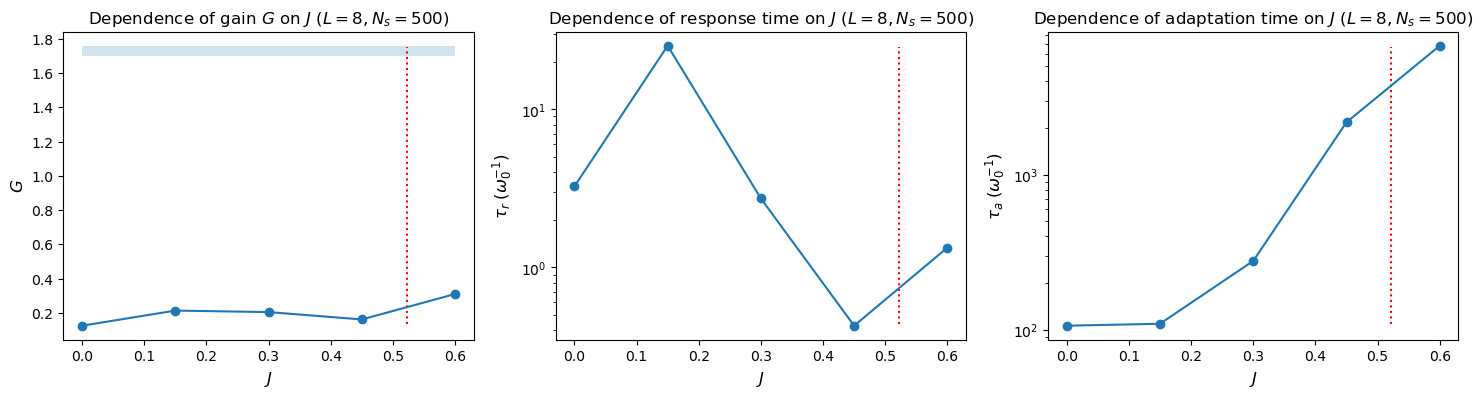

In [13]:
# define the critical value
J_crit_inf = 0.5*np.log(1 + np.sqrt(2))
J_crit_fin = J_crit_inf/(1-1.25/L)

# show how the fitting parameters depend on J
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,4))

for i,ax in enumerate((ax1, ax2, ax3)):
    ax.set_xlabel(r'$J$',size=12)
    ax.axvline(x=J_crit_fin,ymin=0.05,ymax=0.95,linestyle=':',color='r')
    
ax1.plot(J_arr,parm_arr[0,:],'-o')
ax1.fill_between(J_arr,1.70,1.76,alpha=0.2)
ax1.set_ylabel(r'$G$',size=12)
ax1.set_title(f'Dependence of gain $G$ on $J$ ($L={L}, N_s={n_samples}$)')

ax2.semilogy(J_arr,parm_arr[1,:],'-o')
ax2.set_ylabel(r'$\tau_r \; (\omega_0^{-1})$',size=12)
ax2.set_title(f'Dependence of response time on $J$ ($L={L}, N_s={n_samples}$)')

ax3.semilogy(J_arr,parm_arr[2,:],'-o')
ax3.set_ylabel(r'$\tau_a \; (\omega_0^{-1})$',size=12)
ax3.set_title(f'Dependence of adaptation time on $J$ ($L={L}, N_s={n_samples}$)')

plt.show()

**TO DO**: check whether these weird results are due to lmfit or due to tau-leaping